<a href="https://colab.research.google.com/github/ritzi12/SMS_Classification_Using_DistilBERT/blob/main/SpamClassifier_DistilBERT_NNModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#installing transformers package
!pip install transformers

In [160]:
#load packages
import re
import string
import torch
import transformers
import numpy as np # numpy
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.manifold import TSNE   #to visualize the word embeddings
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score,f1_score


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout, Input
import pickle
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [142]:
#Constants
max_len=150
num_classes=2 #we have two classes can make it variable based on unique labels of dataset

In [19]:
#load data

spam_ham_df=pd.read_csv('spam.csv',encoding='latin-1')
spam_ham_df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [20]:
#Data Preprocessing
spam_ham_df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)
spam_ham_df.rename(columns={'v1':'class','v2':'texts'},inplace=True)
spam_ham_df.head()


,class,texts
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [21]:

#Encode class labels 
spam_ham_df["class"].replace({"ham": 0, "spam":1}, inplace=True)

# Count the number of words in the message (\w counts alphanumeric and underscore characters)                  
spam_ham_df['word_count']=spam_ham_df["texts"].apply(lambda s: len(re.findall(r'\w+', s))) 

#Count of characters .i.e. message length
spam_ham_df['msg_length']=spam_ham_df["texts"].apply(lambda s: len(s)) 

spam_ham_df

,class,texts,word_count,msg_length
0,0,"Go until jurong point, crazy.. Available only ...",20,111
1,0,Ok lar... Joking wif u oni...,6,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,33,155
3,0,U dun say so early hor... U c already then say...,11,49
4,0,"Nah I don't think he goes to usf, he lives aro...",14,61
...,...,...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...,33,161
5568,0,Will Ì_ b going to esplanade fr home?,8,37
5569,0,"Pity, * was in mood for that. So...any other s...",10,57
5570,0,The guy did some bitching but I acted like i'd...,27,125


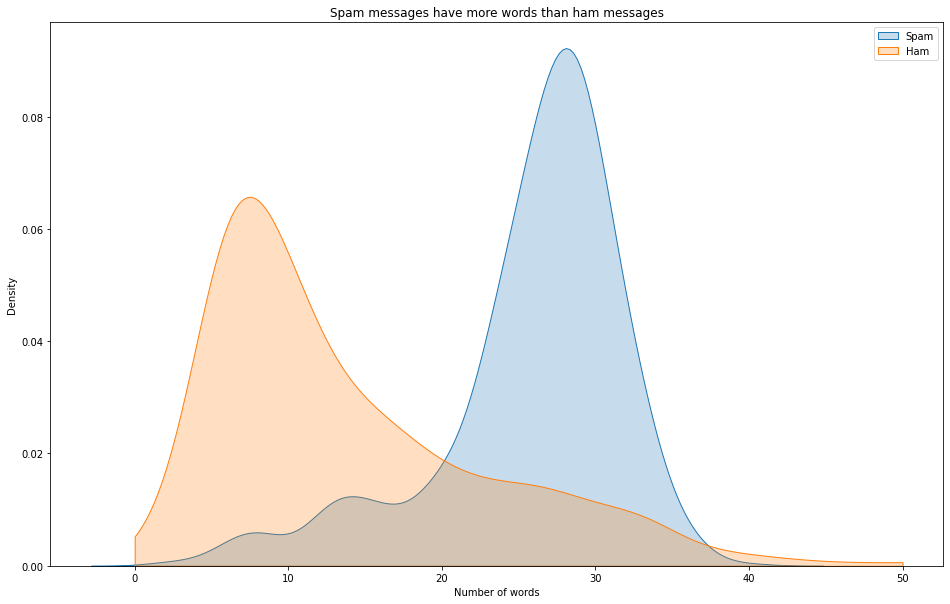

In [24]:
f,ax = plt.subplots(figsize=(16,10))
sns.kdeplot(spam_ham_df.loc[spam_ham_df['class']==1,'word_count'], shade=True, label="Spam")
sns.kdeplot(spam_ham_df.loc[spam_ham_df['class']==0,'word_count'], shade=True, label="Ham",clip=(0,50))
# removing observations with message length above 35 because there is an outlier
ax.set(xlabel = "Number of words", ylabel = "Density",title = "Spam messages have more words than ham messages")
ax.legend()
plt.show()

In [9]:
#Function for Preprocessing Text
def txt_preprocessor(sentences):
  stopword=set(stopwords.words('english'))
  sentences=sentences.lower()
  clean_sent=re.sub('[^a-z]'," ",sentences)
  words=word_tokenize(clean_sent)
  cleaned_words=[w for w in words if w not in stopword]
  cleaned_sent=" ".join(cleaned_words)
  return cleaned_sent
  

In [10]:
#Call preprocessor
spam_ham_df['texts']=spam_ham_df['texts'].apply(txt_preprocessor)

In [47]:
t=spam_ham_df.loc[1578,'texts']
len(t.split())

103

In [61]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
#model = transformers.DistilBertModel.from_pretrained("distilbert-base-uncased")
model_tfdbert = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_projector', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [48]:
#Tokenize
tokenized = spam_ham_df["texts"].apply(lambda x: tokenizer.encode(x, add_special_tokens=True,max_length=200,padding='max_length'))
tokenized

0       [101, 2175, 2127, 18414, 17583, 2391, 1010, 46...
1       [101, 7929, 2474, 2099, 1012, 1012, 1012, 1664...
2       [101, 2489, 4443, 1999, 1016, 1037, 1059, 2243...
3       [101, 1057, 24654, 2360, 2061, 2220, 7570, 209...
4       [101, 20976, 1045, 2123, 1005, 1056, 2228, 200...
                              ...                        
5567    [101, 2023, 2003, 1996, 3416, 2051, 2057, 2031...
5568    [101, 2097, 1045, 1035, 1038, 2183, 2000, 9686...
5569    [101, 12063, 1010, 1008, 2001, 1999, 6888, 200...
5570    [101, 1996, 3124, 2106, 2070, 7743, 2075, 2021...
5571    [101, 20996, 10258, 1012, 2049, 2995, 2000, 20...
Name: texts, Length: 5572, dtype: object

In [50]:
len(tokenized[1000])

200

In [100]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for row in tokenized:
    seq_mask = [ 1 if i!=0 else 0 for i in row ]
    attention_masks.append(seq_mask)

len(attention_masks)  

5572

In [77]:
in_tokenId_array=np.asarray(tokenized[0])
in_mask_array=np.asarray(attention_masks[0])
out=model_tfdbert([in_tokenId_array.reshape(1,-1),in_mask_array.reshape(1,-1)])
print(type(out))
out.last_hidden_state #note the shape of tensor

<class 'transformers.modeling_tf_outputs.TFBaseModelOutput'>


<tf.Tensor: shape=(1, 200, 768), dtype=float32, numpy=
array([[[-0.02585473, -0.3211774 ,  0.17738968, ..., -0.15524201,
          0.43320665,  0.30533102],
        [ 0.09202769, -0.6512531 ,  0.41670665, ..., -0.03499824,
          0.27839342,  0.283761  ],
        [-0.52997065, -0.37653884,  0.31432602, ..., -0.3608728 ,
         -0.10751104,  0.51838726],
        ...,
        [ 0.08904172, -0.0366374 ,  0.38285536, ..., -0.00315545,
         -0.15488456,  0.07060587],
        [ 0.136535  , -0.0884337 ,  0.3743632 , ...,  0.04985102,
          0.00145146, -0.10509698],
        [ 0.2627738 , -0.37265623,  0.40617248, ...,  0.07311359,
          0.06761791, -0.07196748]]], dtype=float32)>

In [78]:
tokenizer.decode(tokenized[0])

'[CLS] go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there got amore wat... [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [143]:
def create_model():
    inps = Input(shape = (max_len,), dtype='int64')
    masks= Input(shape = (max_len,), dtype='int64')
    dbert_layer = model_tfdbert(inps, attention_mask=masks)[0][:,0,:]
    dense = Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(dbert_layer)
    dropout= Dropout(0.5)(dense)
    pred = Dense(num_classes, activation='softmax',kernel_regularizer=keras.regularizers.l2(0.01))(dropout)
    model = tf.keras.Model(inputs=[inps,masks], outputs=pred)
    print(model.summary())
    return model   

In [144]:
model=create_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  multiple            66362880    ['input_13[0][0]',               
 BertModel)                                                       'input_14[0][0]']               
                                                                                                  
 tf.__operators__.getitem_4 (Sl  (None, 768)         0           ['tf_distil_bert_model[4][0

In [145]:
input_ids=[]
attention_masks=[]

for sent in spam_ham_df['texts']:
    dbert_inps=tokenizer.encode_plus(sent,add_special_tokens = True,max_length =max_len,padding='max_length',return_attention_mask = True,truncation=True)
    input_ids.append(dbert_inps['input_ids'])
    attention_masks.append(dbert_inps['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(spam_ham_df['class'])

In [130]:
input_ids.dtype

dtype('int64')

In [146]:
print('Preparing the pickle file.....')

pickle_inp_path='./data/tfdbert_inp.pkl'
pickle_mask_path='./data/tfdbert_mask.pkl'
pickle_label_path='./data/tfdbert_label.pkl'

pickle.dump((input_ids),open(pickle_inp_path,'wb'))
pickle.dump((attention_masks),open(pickle_mask_path,'wb'))
pickle.dump((labels),open(pickle_label_path,'wb'))


print('Pickle files saved as ',pickle_inp_path,pickle_mask_path,pickle_label_path)

Preparing the pickle file.....
Pickle files saved as  ./data/tfdbert_inp.pkl ./data/tfdbert_mask.pkl ./data/tfdbert_label.pkl


In [147]:
print('Loading the saved pickle files..')

input_ids=pickle.load(open(pickle_inp_path, 'rb'))
attention_masks=pickle.load(open(pickle_mask_path, 'rb'))
labels=pickle.load(open(pickle_label_path, 'rb'))

print('Input shape {} Attention mask shape {} Input label shape {}'.format(input_ids.shape,attention_masks.shape,labels.shape))

Loading the saved pickle files..
Input shape (5572, 150) Attention mask shape (5572, 150) Input label shape (5572,)


In [148]:
label_class_dict={0:'ham',1:'spam'}
target_names=label_class_dict.values()

In [149]:
train_inp,val_inp,train_label,val_label,train_mask,val_mask=train_test_split(input_ids,labels,attention_masks,test_size=0.2,random_state=1200)

print('Train inp shape {} Val input shape {}\nTrain label shape {} Val label shape {}\nTrain attention mask shape {} Val attention mask shape {}'.format(train_inp.shape,val_inp.shape,train_label.shape,val_label.shape,train_mask.shape,val_mask.shape))


log_dir='dbert_model'
model_save_path='./dbert_model.h5'

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

Train inp shape (4457, 150) Val input shape (1115, 150)
Train label shape (4457,) Val label shape (1115,)
Train attention mask shape (4457, 150) Val attention mask shape (1115, 150)


In [150]:
callbacks= [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True),keras.callbacks.TensorBoard(log_dir=log_dir)]
model.compile(loss=loss,optimizer=optimizer, metrics=[metric])

In [152]:
history=model.fit([train_inp,train_mask],train_label,batch_size=16,epochs=3,validation_data=([val_inp,val_mask],val_label),callbacks=callbacks)

Epoch 1/3
279/279 [==============================] - ETA: 0s - loss: 5.3780 - accuracy: 0.9910 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


279/279 [==============================] - 3488s 13s/step - loss: 5.3780 - accuracy: 0.9910 - val_loss: 4.6461 - val_accuracy: 0.9919
Epoch 2/3
279/279 [==============================] - 3470s 12s/step - loss: 4.0073 - accuracy: 0.9966 - val_loss: 3.4432 - val_accuracy: 0.9919
Epoch 3/3
279/279 [==============================] - 3457s 12s/step - loss: 2.9198 - accuracy: 0.9989 - val_loss: 2.5150 - val_accuracy: 0.9928


In [157]:
model.save_weights('data/tfdbert_model.h5',save_format='h5')

In [153]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir {log_dir}

In [158]:
trained_model = create_model()
trained_model.compile(loss=loss,optimizer=optimizer, metrics=[metric])
trained_model.load_weights('data/tfdbert_model.h5')

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 150)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  multiple            66362880    ['input_17[0][0]',               
 BertModel)                                                       'input_18[0][0]']               
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, 768)         0           ['tf_distil_bert_model[6][0

In [161]:
preds = trained_model.predict([val_inp,val_mask],batch_size=16)
pred_labels = preds.argmax(axis=1)
f1 = f1_score(val_label,pred_labels)
f1

0.9738562091503268